# LangGraph를 사용한 고객 지원 챗봇을 구축

- 웹 검색을 통해 일반적인 질문에 답변 
- 대화 상태를 유지하여 연속적인 대화  
- 복잡한 질문을 사람이 검토하도록 라우팅  
- 사용자 지정 상태(Custom State)를 활용하여 챗봇의 동작 제어  
- 대화 흐름을 되돌리고(Rewind), 다른 대화 경로 탐색 

In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
# LangSmith 추적 설정 활성화
os.environ["LANGSMITH_TRACING"] = "true"

In [3]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4.1-nano")

먼저 모델을 직접 사용해 봅니다. `ChatModel`은 LangChain의 **"Runnable"** 인스턴스이며, 이는 표준화된 인터페이스를 통해 상호작용할 수 있음을 의미합니다.  

모델을 간단하게 호출하려면 `.invoke` 메서드에 **메시지 목록**을 전달하면 됩니다.

In [4]:
from langchain_core.messages import HumanMessage

response = llm.invoke([HumanMessage(content="안녕! 나는 길동이야.")])
response.content

'안녕, 길동아! 반가워. 오늘 어떻게 도와줄까?'

모델 자체는 **상태(state)** 라는 개념을 가지고 있지 않습니다. 예를 들어, 후속 질문을 하면:

In [5]:
response = llm.invoke([HumanMessage(content="내 이름이 뭐라고 했지?")])
response.content

'죄송하지만, 이전 대화에서 당신의 이름을 알려주지 않으셨기 때문에 이름을 알 수 없습니다.'

In [6]:
from langchain_core.messages import AIMessage

response = llm.invoke(
    [
        HumanMessage(content="안녕! 나는 길동이야."),
        AIMessage(content="안녕하세요, 길동님. 무엇을 도와 드릴까요?"),
        HumanMessage(content="내 이름이 뭐라고 했지?"),
    ]
)

response.content

'길동님이라고 하셨죠!'

<br>
이제 좋은 응답을 받는 것을 확인할 수 있습니다!  

이것이 챗봇이 **대화형 상호작용**을 할 수 있는 기본 아이디어입니다.  

## 챗봇에 메모리 기능 추가¶**  

현재 챗봇은 **사용자 질문에 도구를 활용해 답변할 수 있지만, 이전 대화의 맥락을 기억하지 못합니다.**  
이 때문에 **일관된 멀티턴(Multi-turn) 대화를 진행하는 데 한계가 있습니다.**  

LangGraph는 **"지속적 체크포인트(Persistent Checkpointing)"** 기능을 통해 이 문제를 해결합니다.  

그래프를 컴파일할 때 checkpointing을 활성화하고 그래프를 호출할 때 `thread_id`를 제공하면, LangGraph가 자동으로 상태(state)를 저장하고, 다음 실행 시 이전 상태를 복원합니다.  

즉, **동일한 `thread_id`** 를 사용하여 그래프를 호출하면, 이전 대화 상태를 불러와서 이어서 대화할 수 있습니다!

In [7]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

우리는 현재 **메모리를 활용하는(in-memory) 체크포인터**를 사용하고 있습니다.  

이 방식은 튜토리얼 환경에서는 편리하지만, 데이터가 메모리에만 저장되므로 영구적이지 않습니다. 실제 프로덕션 환경에서는 `SqliteSaver` 또는 `PostgresSaver`를 사용하여 데이터베이스(DB)와 연결하는 것이 일반적입니다.

---

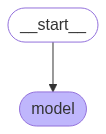

In [8]:
from langgraph.graph import START, MessagesState, StateGraph

# Define a new graph
workflow = StateGraph(state_schema=MessagesState)

# Define the function that calls the model
def call_model(state: MessagesState):
    response = llm.invoke(state["messages"])
    return {"messages": response}

# Define the (single) node in the graph
workflow.add_edge(START, "model")
workflow.add_node("model", call_model)

# Add memory
memory = MemorySaver()
app = workflow.compile(checkpointer=memory)
app

이제 챗봇과 상호작용할 수 있습니다. 먼저, 이 대화를 식별할 수 있는 **`thread`(스레드)** 를 선택합니다.

In [9]:
config = {"configurable": {"thread_id": "1"}}

user_input = [HumanMessage("안녕하세요! 제 이름은 길동이에요.")]

# config는 stream() 또는 invoke()의 두 번째 인자
output = app.invoke(
    {"messages": user_input},
    config,
)

output['messages'][-1].pretty_print()

================================== Ai Message ==================================

안녕하세요, 길동님! 만나서 반가워요. 혹시 도와드릴 일이 있나요?


이제 후속 질문(follow-up question)을 해봅시다. 챗봇이 사용자의 이름을 기억하는지 확인해 봅니다.

In [10]:
user_input = [HumanMessage("내 이름이 뭐야?")]

output = app.invoke(
    {"messages": user_input},
    config,
)

output['messages'][-1].pretty_print()

================================== Ai Message ==================================

당신의 이름은 길동이세요!


In [11]:
config = {"configurable": {"thread_id": "2"}}

user_input = [HumanMessage("내 이름이 뭐야?")]

output = app.invoke(
    {"messages": user_input},
    config,
)

output['messages'][-1].pretty_print()

================================== Ai Message ==================================

죄송하지만, 저는 당신의 이름을 알지 못합니다.


In [12]:
config = {"configurable": {"thread_id": "1"}}
user_input = [HumanMessage("내 이름이 뭐야?")]

output = app.invoke(
    {"messages": user_input},
    config,
)

output['messages'][-1].pretty_print()

================================== Ai Message ==================================

당신의 이름은 길동이세요!


### 프롬프트 템플릿(Prompt Templates)을 사용하여 LLM 호출 최적화

**프롬프트 템플릿** 은 **원시 사용자 입력(raw user input)** 을 LLM이 처리할 수 있는 형식으로 변환하는 데 도움을 줍니다.   

1. 먼저, **시스템 메시지(system message)** 를 추가하여 **사용자 정의 지침(custom instructions)** 을 포함시킵니다. (여전히 메시지를 입력으로 사용)  
2. 다음으로, 메시지 외에 **더 많은 입력 정보** 를 추가합니다.  

#### **시스템 메시지(System Message) 추가하기**

시스템 메시지를 추가하기 위해 **`ChatPromptTemplate`** 을 생성합니다. 여기서는 메시지 전달을 위해 **`MessagesPlaceholder`** 를 사용하겠습니다.  

이렇게 하면 LLM에 전달되는 입력이 더 구조화되고, 챗봇의 동작을 더 정교하게 제어할 수 있습니다.  

In [13]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

# LLM이 사용자 입력을 더 잘 처리할 수 있도록 프롬프트 템플릿을 설정합니다.
prompt_template = ChatPromptTemplate.from_messages(
    [
        # LLM의 동작 방식을 정의하는 지침
        (
            "system",
            "당신은 친구 처럼 말합니다. 모든 질문에 최선을 다해 대답하세요.",
        ),

        # Messages Placeholder - 이전 대화 메시지들을 전달합
        MessagesPlaceholder(variable_name="messages"),
    ]
)

이제 이 템플릿을 통합하여 애플리케이션을 업데이트할 수 있습니다.

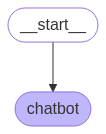

In [18]:
from langgraph.graph import START, MessagesState, StateGraph

# 상태 스키마(State)를 정의하여 그래프 생성기 초기화
workflow = StateGraph(state_schema=MessagesState)

# 모델 호출 함수 정의
def chatbot(state: MessagesState):
    # 현재 상태(state)에 포함된 메시지를 기반으로 프롬프트 생성
    prompt = prompt_template.invoke(state)
    
    # 생성된 프롬프트를 LLM에 전달하여 응답을 생성
    response = llm.invoke(prompt)
    
    # LLM 응답을 딕셔너리 형태로 반환 (다음 상태로 전달됨)
    return {"messages": response}

# chatbot 노드를 그래프에 추가
workflow.add_node("chatbot", chatbot)

# MemorySaver를 사용하여 대화 상태를 저장할 메모리 객체 생성
memory = MemorySaver()


# 그래프의 시작 지점(START)에서 chatbot 노드로 연결
workflow.add_edge(START, "chatbot")

# 모든 구성 요소를 종합하여 그래프를 컴파일 (메모리를 체크포인터로 사용)
graph = workflow.compile(checkpointer=memory)

# 컴파일된 그래프 객체를 확인
graph

In [19]:
# 'configurable' 키를 사용하여 추가적인 설정 값을 전달합니다.
# 여기서는 'thread_id'를 사용하여 특정 대화 스레드를 식별합니다.
config = {"configurable": {"thread_id": "abc345"}}

# 메시지 목록에 사용자 메시지 추가
input_messages = [HumanMessage("안녕. 나는 길동이야.")]

# 애플리케이션 호출
# 메시지 상태(State), 설정(config) 전달
output = graph.invoke({"messages": input_messages}, config)

output["messages"][-1].pretty_print()

================================== Ai Message ==================================

안녕 길동아! 반가워. 오늘 하루는 어때? 뭐 하고 지내?


In [20]:
# 'configurable' 키를 사용하여 추가적인 설정 값을 전달합니다.
# 여기서는 'thread_id'를 사용하여 특정 대화 스레드를 식별합니다.
config = {"configurable": {"thread_id": "abc345"}}

# 메시지 목록에 사용자 메시지 추가
input_messages = [HumanMessage("내 이름이 뭐지?")]

# 애플리케이션 호출
# 메시지 상태(State), 설정(config) 전달
output = graph.invoke({"messages": input_messages}, config)

output["messages"][-1].pretty_print()

================================== Ai Message ==================================

네 이름은 길동이야! 맞지?


### 무한 loop 로 Chatbot 구현

In [21]:
# 'configurable' 키를 사용하여 추가적인 설정 값을 전달합니다.
# 여기서는 'thread_id'를 사용하여 특정 대화 스레드를 식별합니다.
memory = MemorySaver()

# 그래프를 메모리 체크포인트와 함께 컴파일합니다.
graph = workflow.compile(checkpointer=memory)

config = {"configurable": {"thread_id": "abc345"}}

while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break

    output = graph.invoke({"messages": user_input}, config)
    output["messages"][-1].pretty_print()

User:  안녕 나는 길동이야


================================== Ai Message ==================================

안녕 길동이! 반가워. 오늘 하루는 어땠어? 뭐 궁금한 거 있으면 언제든 말해줘!


User:  내 이름이 뭐지?


================================== Ai Message ==================================

너의 이름은 길동이야! 맞지? 😊


User:  q


Goodbye!


------------
이제는 chatbot이 외부 정보를 접근할 수도 있고 대화 내용을 기억할 수도 있습니다.